First, let's import all the packages we will need for this project

In [1]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='svg'

Configure pandas

In [2]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', None)

To see the disease development over time, let's access the Covid-19 data API kindly provided by the [Johns Hopkins CSSE](https://covid19api.com/).

[Postman COVID-19 API Resource Center](https://covid-19-apis.postman.com/)

In [3]:
def timeSeriesInstructions():
    
    r = requests.get('https://api.covid19api.com/')
    instructions_dic = r.json()
    instructions = pd.DataFrame.from_dict(instructions_dic).transpose()
    
    return instructions

In [4]:
def testTimeSeriesInstructions():
    
    try:
        instructions = timeSeriesInstructions()
        assert instructions.empty == False
        print("Congrats, tests for timeSeriesInstructions() function have been passed.")
    except:
        print('Assertion error detected. Please, inspect timeSeriesInstructions() function.')
testTimeSeriesInstructions()

Congrats, tests for timeSeriesInstructions() function have been passed.


In [5]:
def filterDate(data, date = '2020-03-01'):
    
    filter_date = data['Date'] >= date
    data = data[filter_date]
    
    return data

In [6]:
def timeSeriesData(list_countries = ['estonia', 'latvia', 'lithuania']):

    data = []

    for country in list_countries:
        r = requests.get(f'https://api.covid19api.com/country/{country}')
        data_dic = r.json()
        raw_data = pd.DataFrame.from_dict(data_dic)

        filter_province = raw_data['Province'] != ''
        raw_data.drop(index = raw_data[filter_province].index, inplace = True)

        filter_columns = ['CountryCode', 'Province', 'City', 'CityCode', 'Lat', 'Lon', 'Active']
        raw_data.drop(columns = filter_columns, inplace = True)

        raw_data['Date'] = pd.to_datetime(raw_data['Date'], format = '%Y-%m-%dT%H:%M:%SZ')
        
        numeric_columns = ['Confirmed', 'Deaths', 'Recovered']
        raw_data[numeric_columns] = raw_data[numeric_columns].apply(pd.to_numeric)

        data.append(raw_data)

    data = pd.concat(data)

    column_names = ['Country', 'Date', 'Confirmed', 'Deaths', 'Recovered']
    data = data.reindex(columns = column_names)

    data = filterDate(data)
    country_group = data.groupby('Country')    

    return country_group

In [7]:
def pickCountry(country_group, country_name):
    
    country_name = country_name.title()
    ts_data = country_group.get_group(country_name)
    ts_data.reset_index(drop = True, inplace = True)
    
    return ts_data

In [8]:
def dailyChanges(ts_data, prc = False, periods = 1):
    numeric_columns = ['Confirmed', 'Deaths', 'Recovered']
    legend_data = ts_data[['Country', 'Date']]

    if (prc):
        change_data = round(100 * ts_data[numeric_columns].pct_change(periods = periods), 2)
        change_data.replace([np.inf, np.nan], 0, inplace = True)
    else:
        change_data = ts_data[numeric_columns].diff(periods = periods)
        change_data.replace([np.inf, np.nan], 0, inplace = True)
        change_data = change_data.astype(int)

    diff_data = pd.concat([legend_data, change_data], axis = 1)
    
    upper_bound = diff_data.index[:periods]
    diff_data.drop(labels = upper_bound, axis = 0, inplace = True)
    
    diff_data.reset_index(drop = True, inplace = True)

    return diff_data

In [9]:
def testTimeSeriesData():
    
    test = timeSeriesData()
    test = pickCountry(test, 'Latvia')
    
    try:
        assert test['Date'].iloc[0] == datetime.strptime('2020-03-01', '%Y-%m-%d')
        assert list(test.columns) == ['Country', 'Date', 'Confirmed', 'Deaths', 'Recovered']
        assert type(test['Confirmed'].iloc[0]) == np.int64        
        print("Congrats, tests for timeSeriesData() function have been passed.")       
    except:
        print('Assertion error detected. Please, inspect timeSeriesData() function.')
        
    test_diff = dailyChanges(test, prc = False)
    test_pct = dailyChanges(test, prc = True)
    
    max_index = len(test['Confirmed']) - 1
    index = np.random.randint(low = 1, high = max_index)
    calculation_pct = round(100 * (test['Confirmed'].iloc[index]/test['Confirmed'].iloc[index-1] - 1), 2)
    if (calculation_pct == np.inf) or (calculation_pct == np.nan):
        calculation_pct = 0
        
    calculation_diff = test['Confirmed'].iloc[index] - test['Confirmed'].iloc[index - 1] 
        
    try:    
        assert calculation_pct == test_pct['Confirmed'].iloc[index-1]
        assert calculation_diff == test_diff['Confirmed'].iloc[index-1]
        print("Congrats, tests for dailyChanges() function have been passed.")        
    except:
        print('Assertion error detected. Please, inspect dailyChanges() function.')   
        
testTimeSeriesData()

Congrats, tests for timeSeriesData() function have been passed.
Congrats, tests for dailyChanges() function have been passed.


To see more insights of the current situation, let's extract cross-sectional data from the [NovelCOVID API](https://github.com/javieraviles/covidAPI)

In [10]:
def crossSectionalData():
    
    r = requests.get('https://coronavirus-19-api.herokuapp.com/countries')
    cs_data_dic = r.json()
    cs_data = pd.DataFrame.from_dict(cs_data_dic)
    
    cs_data = cs_data.loc[1:]
    
    cs_data = cs_data.apply(pd.to_numeric, errors = 'ignore')
    cs_data.sort_values('cases', ascending = False, inplace = True)
    
    cs_data['Population (M)'] = round((cs_data['cases'] / cs_data['casesPerOneMillion']), 2)
    
    cs_data['Population (M)'].replace([np.inf, 0], np.nan, inplace = True)
    cs_data.dropna(axis = 0, subset = ['Population (M)'], inplace = True)
    
    filter_columns = ['todayCases', 'todayDeaths', 'active', 'critical', 'casesPerOneMillion', 'deathsPerOneMillion', 'testsPerOneMillion']
    cs_data.drop(columns = filter_columns, inplace = True)
    
    cs_data.columns = cs_data.columns.str.title()
    cs_data.rename(columns = {'Totaltests': 'Tested'}, inplace = True)
    cs_data.reset_index(drop = True, inplace = True)
    
    return cs_data

For some reason China is missing. Some countries are reporting 0 cases per million of populations, hence their population is being astimated to be equal to infinity. As thsese countries do not impact the analysis much, I just remove these observations from the dataset. 

In [11]:
def aggregate(number_of_countries, include_other = True):
    
    cs_data = crossSectionalData()
    lower_bound = number_of_countries + 1
    
    agg_part = cs_data.iloc[lower_bound:]
    non_agg_part = cs_data.iloc[:number_of_countries] 
    
    other_row = agg_part.sum(numeric_only=True)
    other_row['country'] = 'Other countries*'
    
    if (include_other):
        agg_data = non_agg_part.append(other_row, ignore_index=True)
    else:
        agg_data = non_agg_part
        
    return agg_data


In [12]:
def testCrossSectionalData():
    
    test = crossSectionalData()
    
    upper_bound = len(test['Cases']) - 1
    number_of_countries = np.random.randint(low = 0, high = upper_bound)
    
    try:
        assert list(test.columns) == ['Country', 'Cases', 'Deaths', 'Recovered', 'Tested', 'Population (M)']
        assert type(test['Cases'].iloc[0]) == np.int64
        print('Congrats, tests for crossSectionalData() function have been passed.')
    except:
        print('Assertion error detected. Please, inspect crossSectionalData() function.')
        
    test_top = aggregate(number_of_countries, False)
    test_agg = aggregate(number_of_countries, True)
    
    try:
        assert len(test_top['Cases']) == number_of_countries
        assert len(test_agg['Cases']) == number_of_countries + 1
        print('Congrats, tests for aggregate() function have been passed.')
    except:
        print('Assertion error detected. Please, inspect aggregate() function.')
  

timeSeriesInstructions()

filterDate(data, date = '2020-03-01')

timeSeriesData(list_countries = \['estonia', 'latvia', 'lithuania'\])

pickCountry(country_group, country_name)

dailyChanges(ts_data, prc = False, periods = 1)


crossSectionalData()

aggregate(number_of_countries, include_other = True)


First, let's plot some time series data



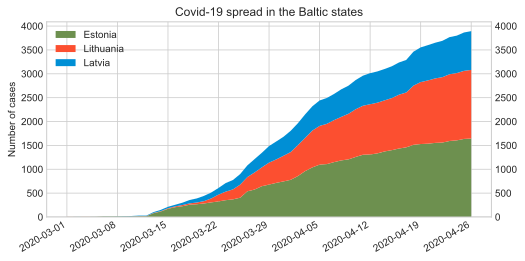

In [14]:
# Plot Baltic countries cases over time (stack plot)

data = timeSeriesData()

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

latvia = pickCountry(data, 'Latvia')
lithuania = pickCountry(data, 'Lithuania')
estonia = pickCountry(data, 'Estonia')    

x_axis = latvia['Date']

y_axis1 = estonia['Confirmed']  
y_axis2 = lithuania['Confirmed']
y_axis3 = latvia['Confirmed']

labels = ['Estonia', 'Lithuania', 'Latvia']
colors = ['#6d904f', '#fc4f30', '#008fd5']

fig, ax = plt.subplots()

fig.autofmt_xdate()
ax.stackplot(x_axis, y_axis1, y_axis2, y_axis3, labels=labels, colors=colors)
ax.legend(loc = 'upper left')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))

plt.title('Covid-19 spread in the Baltic states')
plt.ylabel('Number of cases')
plt.tick_params(labelright=True)

plt.show()